### CODE OF NEURAL-ODE/SDE EXAMPLES

The code implements a version of Neural-SDE where training is performed through backpopagation through time. 
This version assumes that the data are sampled at discretization steps $\delta t$. However, it can be easily generalised.

The code permits to train the neural network to replicate the dynamics of two example dynamical systems: a non linear leaky integrator with colored noise, and the Duffing oscillator with colored noise. 
Moreover, it is possible to train the system to reproduce the behaviour of a neuromorphic computing system based on magnetic nanorings. 
On the Setting_Variables file, set Dynamical_System='LI' for the leaky integrator, Dynamical_System='DO' for Duffing oscillator, and Dynamical_System='Rings' for the experimental data on the neuromorphic system.
For the two analytical systems ('LI' and 'DO'), the class Generate_Data is used to generate trajectories of respones.

The code is subdivided into the following files:

- Setting_Variables is used to intialise global variables, i.e. to define the system to train, the parameters affecting its dynamics. <br>  <br>



- Neural_SDE, the current file, is the main script to run. <br>  <br>



- SDE_Int_Methods, contains the numerical methods to simulate the dynamical system considered, or to compute the Neural-ODE/SDE activities. For training the Neural-ODE only, standard RK2 and RK4 are implemented. For the SDE, stochastic variants of RK2 and RK4 are implemeted. Choosing RK2 or RK4 can be done from the Setting_Varibales script defining RK=2 or RK=4. The file contains also the Generate_Data class, used to generate training/validation/testing data for the analytical systems, and the Autocov class, adopted to compute errors between the statics of the generated trajectories (generated by the Neural-ODE/SDE) and the target ones. Considering a numerical method $\rm{NM}$, it will receive a deterministic function F and, for SDEs, a stochastic function G as arguments, to integate $\mathrm{d}\mathbf{x}=\mathbf{F} \rm{dt}+\mathbf{G} \rm{d}\mathbf{W}$, where $\rm{d}\mathbf{W}$ is the Wiener process (not to be confused with the parameters $\mathbf{W}$).  <br>  <br>



- Function_Modules. The components of the Neural-ODE/SDE models. As depicted in the scheme below, a Neural-SDE is composed by a determinstic network F and a stochastic network G. <br> <strong>On the F and G networks </strong>. These networks are defined in the F_Module class and the G_Module class of the script respectively. Both the F and the G network receives information about the past state of the system and the external signal as inputs. Let's define the observable/measurable (the system might be more complex than the variables that we can actually measure) activity of the considered dynamical system as $\mathbf{x}(t)$, whose dimensionality is $\rm{N_X}$, and the external input as $\mathbf{s}(t)$, whose dimensionality is $\rm{N_S}$ (code names are analogous). The Neural-ODE/SDE should receive as input $\Big( \mathbf{s}(t), \mathbf{x}(t), \mathbf{x}(t-\delta t), ..., \mathbf{x}(t-N_{delay}\delta t) \Big)$, where $N_{delay}$ defines the number of past observation $\mathbf{x}$ to include in the model's input. The reason of this additional $N_{delay}$ hyperparameter lies in the feedforward structure of the F and G networks. As a consequence, the input to the Neural-ODE/SDE "should" have the necessary information to approximate and predict the next step observation effectively, or ideally, the representation of the system should be Markovian. As a consequence, the input to the network can be augmented through $N_{delay}$ to include additional past information. We notice how, for a dynamical system with an underlying set of differential equations and observation of a limited subset of its variables, an appropriate $N_{delay}$ reflects the order of the considered differential equation. Thus, the input dimensionality of the networks F and G is $\rm{N_X}(N_{delay}+1)+\rm{N_S}$. The output dimensionality of F is instead $\rm{N_X}(N_{delay}+1)$, i.e the dimensionality of all the activities $\mathbf{x}$ given as input (indeed, after numerical integration, the model should predict the next state of the system's input variables). The output dimensionality of G is $\Big(\rm{N_X}+\rm{N_{a}\Big)\rm{N_{W}}}$, where $\rm{N_{a}}$ are auxiliary variables to introduce colored noise through multiple time constants $\boldsymbol{\theta}$  (See Eq.1 below) and $\rm{N_{W}}$ is the noise dimensionality. <br> <strong> G2F_Module and auxiliary variables </strong>. The G network deals exclusively with the stochastic part $G \rm{d}W$, it is indeed the G function, while the (deterministic) effect of the stochastic component G on the deterministic F is defined through the G2F_Module class, whose relevant object is initialised inside the F_Module. The G2F_Module is responsible for decaying the auxiliary variables $\mathbf{a}$ by the defined timescales $-\boldsymbol{\theta}$ and to compute the contribution of the auxiliary variables to the observable $\mathbf{x}(t)$ through the matrix $\mathbf{W}_{a}$. We notice how this contribution should be on the more recent temporal observation of $\mathbf{x}(t)$, and not on all delays, otherwise we would be modifying the noise affecting the system for every update of the numerical method.<br> <strong> On the D_Module </strong>. The stochastic components G and the G2F_Module parameters ($-\boldsymbol{\theta}$ and $\boldsymbol{W}_{a}$) are optimised following a generative adversarial network paradigm. Thus, the discriminator D is defined in the D_Module, which in the current setting is a simple MLP. For the network modules F, G, D it is possible to adopt temporal convolutions by including the temporal convolution class. <br>  <br>
 


- DO_Definition and LI_Definition contain the definitions of the functions for the Leaky integrator and Duffing oscillator. These functions will be called by the numerical method.


The equations for the Neural-SDE definition and the corresponding scheme are given below.


$$\rm{d}\mathbf{x}_t=\Big(\mathbf{F}+W_a \mathbf{a}(t)\Big)\rm{d}t+G_{x} \rm{d}\mathbf{W}_t\\
\rm{d}\mathbf{a}_t=-\boldsymbol{\theta}\mathbf{a}_t+\mathbf{G}_a \rm{d}\mathbf{W}_t
$$

In the implementation, the G_Module is the concatenation of $G_x$ and $G_a$ for convenience.


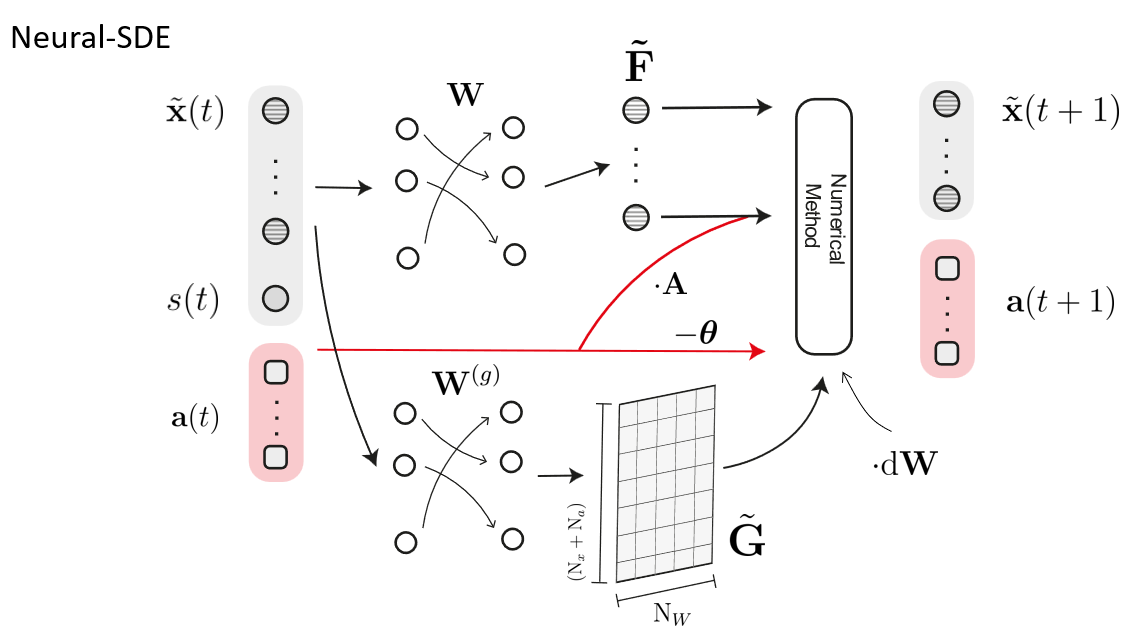

IMPORTANT REMARK ON THE INPUTS AND TARGETS. The Neural_SDE class below accepts input and target trajectories as arguments. The first N_S dimensions of the input trajectories contain the external signal, while the other dimensions are dedicated to the system activities. At time t, the input trajectory should contain the external signal at time t, and then the activities of the system at time t-1 (from this information we want to predict the activities at t). In contrast, the target trajectories contain only the activities of the system, shifted by one step in camparison to the input activities.

In [1]:
## IMPPORTING PACKAGES

import torch
import numpy as np
torch.cuda.is_available()
import torchvision
import torchvision.datasets as datasets
import time
import torch.jit as jit
from torch import nn
from torch import optim
import os
from scipy import io
import pickle
device='cuda'
torch.set_default_tensor_type(torch.FloatTensor)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.autolayout"] = True

from Setting_Variables import *

from SDE_Int_Methods import *
from Functions_Modules import *



/home/luca/anaconda3/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
## THE CLASS TO DEFINE NEURAL ODE/SDE AND TRAIN IT

class NeuralSDE_BPTT(nn.Module):
    
    def __init__(self, F_Ns, G_Ns, D_Ns, N_aux, N_ext_aux, sigmas_model,\
                 load_weightsF=[],load_weightsD=[]):
        super().__init__()
        
        self.N_aux=N_aux                    ## NUMBER OF AUXILIARY VARIABLES USED
        self.N_ext_aux=N_ext_aux            ## NUMBER OF EXTERNAL AUXILIARY VARIABLES ADOPTED (I would set this to zero, it is an experimental feature)
        self.NX_dim=NX_dim                  ## OBSERVABLE DIMENSIONALITY OF THE SYSTEM (OF X, WHAT I CALLED IN THE INTRODUCTION N_X)
        self.N_X=F_Ns[-1]                   ## FULL DIMENSIONALITY OF THE CONSIDERED VALUES OF X, INCLUDING THE DELAYS
        self.N_S=N_S                        ## DIMENSIONALITY OF THE EXTERNAL INPUS SIGNAL
        
        self.F_Ns=F_Ns                      ## NUMBER OF NODES AND LAYERS OF THE DETERMINISTIC F FUNCTION. For instance, F_Ns=[5,200,200,4] corresponds to a 
                                            ## neural network with a 5-d input, one hidden layer with 200 nodes...output layer with 4 nodes
        self.G_Ns=G_Ns                      ## NUMBER OF NODES AND LAYERS OF THE STOCHASTIC G FUNCTION.
        self.D_Ns=D_Ns                      ## NUMBER OF NODES AND LAYERS OF THE DISCRIMINATOR D.
        
        
        ## INITIALISATION OF F
        self.F=F_Module(F_Ns, N_aux, N_ext_aux, load_weights=load_weightsF).to(device) 
        
        ## INITIALISATION OF G
        self.G=G_Module(G_Ns, F_Ns, N_aux+N_ext_aux, sigmas_model).to(device)          
        
        ## INITIALISATION OF D
        self.D=D_Module(D_Ns,load_weightsD).to(device)
              
        ## PARAMETERS FOR EFFECT OF THE EXTERNAL VARIABLES (SHOULD BE EMPTY)    
        self.W_ext=torch.nn.Parameter(torch.ones([N_ext_aux,self.NX_dim],device=device))
        
        ## SDE=TRUE WILL DEFINE AN SDE, EXPLOITING A STOCHASTIC NUMERICAL METHOD, SDE=FALSE DEFINES AN ODE
        self.SDE=True
        
    def Initialise_Hyperparameters(self,dt,etas,lamda,sigmas_model,Train_Type):
        
        
        self.dt=dt                              ## VALUE OF THE DISCRETIZATION STEP
        self.sigmas_model=sigmas_model          ## BINARY TENSOR DEFINING WHERE THE NOISE IS INTRODUCED ACROSS VARIABLES
                                                ## Practically, it is a multiplicative factor sigma_model*G*dW,
                                                ## so setting this to zero on dimension i will suppress the noise contribution on that dimension
        
        self.Int_Sde=SDE_IntMethods(self.F,self.G,self.sigmas_model,self.dt) ## Definition of the SDE integration method,
                                                                             ## where the F and G functions are the neural networks F_Module, G_Module
        
        self.Int_Ode=ODE_IntMethods(self.F,self.dt)
        
        self.etas=etas                          ## Learning rates for deterministic (etas[0]), stochastic (etas[1]) and G2F parameters (etas[2])
        
        self.opt_F=optim.Adam( self.F.F.parameters(), lr=etas[0] ) ## Optimizer for deterministic F
        
        if self.N_aux==0 and self.N_ext_aux==0: ## True if auxiliary variables are present
            
            self.opt_G=optim.Adam( self.G.parameters(), lr=etas[1], betas=(0., 0.9) ) ## Optimizer for stochastic G  
            
        else:
            
            self.opt_G=optim.Adam( self.G.parameters(), lr=etas[1], betas=(0., 0.9) ) ## Optimizer for stochastic G 
                        
            self.opt_G_noise=optim.Adam( self.F.G2F.parameters(), lr=etas[2], betas=(0., 0.9) ) ## Optimizer for G2F parameters

        
        self.opt_D=optim.Adam( self.D.parameters(), lr=etas[1], betas=(0., 0.9) ) ## Optimizer for the discriminator
        
        self.lamda=lamda  ## Magnitude of the gradient penalty contribution, usually ten
        
        self.Train_Type=Train_Type ## Training type performed by the neural-SDE
        
    def Override_G(self,G_Ns,N_aux,N_ext_aux,sigmas_model):
        
        
        self.N_aux=N_aux                    
        self.N_ext_aux=N_ext_aux            
        self.G_Ns=G_Ns
        
        ## INITIALISATION OF G
        self.G=G_Module(G_Ns, F_Ns, N_aux+N_ext_aux, sigmas_model).to(device)  
        
        
        if self.N_aux==0 and self.N_ext_aux==0: ## True if auxiliary variables are present
            
            self.opt_G=optim.Adam( self.G.parameters(), lr=etas[1], betas=(0., 0.9) ) ## Optimizer for stochastic G  
            
        else:
            
            self.opt_G=optim.Adam( self.G.parameters(), lr=etas[1], betas=(0., 0.9) ) ## Optimizer for stochastic G 
                        
            self.opt_G_noise=optim.Adam( self.F.G2F.parameters(), lr=etas[2], betas=(0., 0.9) ) ## Optimizer for G2F parameters
        
        ## PARAMETERS FOR EFFECT OF THE EXTERNAL VARIABLES (SHOULD BE EMPTY)    
        self.W_ext=torch.nn.Parameter(torch.ones([N_ext_aux,self.NX_dim],device=device))
        self.Int_Sde=SDE_IntMethods(self.F,self.G,sigmas_model,self.dt)
        
    
    def Reset(self,t0,X0):   ## Reset of the activities of the system, i.e. we are starting to compute a new trajectory
        
        self.t=t0
        self.X=torch.clone(X0)
    
    
    def SDE_step(self, Input): ## Step of the Numerical method
        
        ## SDE numerical method
        if self.SDE:
            
            ## Runge-Kutta 4
            if RK==4:

                self.X=self.Int_Sde.RK4(self.X,Input,self.t)
            
            ## Runge-Kutta 2
            if RK==2:

                self.X=self.Int_Sde.RK2(self.X,Input,self.t)
        
        ## ODE numerical methods
        else:
            
            ## Runge-Kutta 4
            if RK==4:

                self.X=self.Int_Ode.RK4(self.X,Input,self.t)
            
            ## Runge-Kutta 2
            if RK==2:

                self.X=self.Int_Ode.RK2(self.X,Input,self.t)
        
        self.t=self.t+self.dt
    
    ## METHOD COMPUTING A TRAJECTORY GIVEN THE Inputs...in this case, gradients are not calculated
    ## and this method should be used for evaluation
    def SDE_Seqforward(self,Inputs,t0):
        
        with torch.no_grad():
            
            X=self.forward(Inputs,t0)
            
        return X
    
    ## FORWARD PASS, BUT COMPUTING THE GRADIENTS
    def forward(self,Inputs,t0):
        
        T=Inputs.size()[2]
        batch_size=Inputs.size()[0]
        X=torch.zeros([batch_size,self.N_X,T],device=device)
        
        if self.N_aux==0 and self.N_ext_aux==0:
            
            ## THE ACTIVITIES OF THE SYSTEM ARE FROM N_S ONWARDS...SO WE CAN USE THEM AT TIME T0 FOR INITIALISATION
            self.Reset(t0,Inputs[:,self.N_S:,0])
            
            print('After_Reset')
            
        else:
            
            ## HERE THE AUXILIARY VARIABLES ARE INITIALISED AS 0
            X_reset=torch.concat([Inputs[:,self.N_S:,0],\
                                  torch.zeros([Inputs.size()[0],self.N_aux+self.N_ext_aux],device=device)],1)
            self.Reset(t0,X_reset)
       
        ## COMPUTATION OF DYNAMICS
        for t in range(T):
            
            
            self.SDE_step(Inputs[:,0:self.N_S,t])
            X[:,:,t]=torch.clone(self.X[:,0:self.N_X])
            
            if self.N_ext_aux>0:
                X[:,0:self.NX_dim,t]=X[:,0:self.NX_dim,t]+torch.matmul(self.X[:,-self.N_ext_aux:],self.F.G2F.W_ext)
            
        return X
    
    ## METHOD TO TRAIN THE DISCRIMINATOR
    def Train_D(self,Inputs,real_data_original,t0):
        
        with torch.no_grad():
            
            ## Generation of fake trajectories by the SDE
            fake_data_original=self.forward(Inputs,t0)
        
        ## Resetting accumulated gradients in the discriminator
        self.opt_D.zero_grad()
        
        ## Preparing the data for the discriminator
        real_data_original=real_data_original[:,0:self.NX_dim,:]
        fake_data_original=fake_data_original[:,0:self.NX_dim,:]
        
        
        #External_S=torch.clone(torch.reshape(Inputs[:,0,:],[fake_data_original.size()[0],-1]))
        External_S=torch.clone(torch.reshape(Inputs[:,0:N_S,:],[fake_data_original.size()[0],-1]))

        fake_data=torch.reshape(fake_data_original,[fake_data_original.size()[0],-1])        
        fake_data=torch.concat([fake_data,External_S],1)

        real_data=torch.reshape(real_data_original,[fake_data.size()[0],-1])
        real_data=torch.concat([real_data,External_S],1)
        
        ## Computation of discriminator response for fake data
        
        D_real, _=self.D(real_data)
        D_real=-D_real.mean()
        D_real.backward()
        
        ## Computation of discriminator response for real data
        D_fake, _=self.D(fake_data)
        D_fake=D_fake.mean()
        D_fake.backward()
        
        ## Gradient penalty
        GP=self.calc_gradient_penalty(real_data,fake_data)
        GP=torch.mean(GP)
        GP.backward()
        
        ## Computation of loss function for visualization purposes
        D_cost = (D_fake - D_real + GP).detach()
        D_W = (D_real - D_fake).detach()
        
        ## Optimizer step
        self.opt_D.step()
        
        return D_cost, D_W, fake_data_original
    
    def Train_F(self,Inputs,Targets,t0):
        
        self.opt_F.zero_grad()
        
        if (self.N_aux+self.N_ext_aux)>0:
            self.opt_G_noise.zero_grad()
        
        T=Targets.size()[2]
        
        X=self.forward(Inputs,t0)
        
        #mse=torch.mean(torch.sum(torch.mean((Targets[:,:,:]-X[:,:,:]),1),1))
        mse=torch.mean(torch.sum(torch.mean((Targets[:,:,:]-X[:,:,:])**2,1),1))
        
        Err=mse
        Err.backward()
                
        self.opt_F.step()
                
        return Err
        
    
    def Train_G(self,Inputs,real_data_original,t0,Train_F=False):
        
        self.opt_G.zero_grad()
        self.opt_D.zero_grad()
        self.opt_F.zero_grad()
        
        if (self.N_aux+self.N_ext_aux)>0:
            self.opt_G_noise.zero_grad()
        
        
        fake_data_original=self.forward(Inputs,t0)
        fake_data_original=fake_data_original[:,0:self.NX_dim,:]
        real_data_original=real_data_original[:,0:self.NX_dim,:]

        fake_data=torch.reshape(fake_data_original,[fake_data_original.size()[0],-1])
        real_data=torch.reshape(real_data_original,[real_data_original.size()[0],-1])
        External_S=torch.clone(torch.reshape(Inputs[:,0:N_S,:],[fake_data.size()[0],-1]))
        
        fake_data=torch.concat([fake_data,External_S],1)
        real_data=torch.concat([real_data,External_S],1)

        D_fake, Df_fake=self.D(fake_data)
        
        G_cost=torch.zeros([np.shape(self.Train_Type)[0]])
        
        
        ## DEFINITION OF LOSS FUNCTION (which varies depending on the option selected)
        ## and generator optimizer step
        if self.Train_Type[0]==1:
        
            D_fake_E=-D_fake.mean()
            D_fake_E.backward(retain_graph=True)
        
            G_cost[0]=(-D_fake_E).detach()
        
        if np.sum(self.Train_Type[1:])>0:
            
            D_real, Df_real=self.D(real_data)
        
        if self.Train_Type[1]==1:
            
            D_mean_E=torch.mean(torch.pow(torch.mean(Df_fake,0)-torch.mean(Df_real,0),2),)
            D_mean_E.backward(retain_graph=True)
            G_cost[1]=(D_mean_E).detach()
            
        if self.Train_Type[2]==1:
            
            D_var_E=torch.mean(torch.pow(torch.sqrt(torch.var(Df_fake,0))-                                                   torch.sqrt(torch.var(Df_real,0)),2))
            D_var_E.backward(retain_graph=True)
            G_cost[2]=(D_var_E).detach()
        
        self.opt_G.step()
        
        if self.N_aux>0 or self.N_ext_aux>0:
        
        	self.opt_G_noise.step()
        
        if Train_F:
        
            self.opt_F.step()
        
        return G_cost, fake_data_original
    
    ## Gradient penalty computation 
    def calc_gradient_penalty(self, real_data, fake_data):
        
        batch_size=real_data.size()[0]
            
        alpha = torch.rand([batch_size, 1],device=device)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates.requires_grad_()

        disc_interpolates, _ = self.D(interpolates)
        
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        GP = ((gradients.reshape([gradients.size()[0],-1]).norm(2, dim=1) - 1) ** 2).mean() * self.lamda
        
        return GP

### To select the desired Dynamical systems change the Setting Variables file and rerun the cells

Change the variable Dynamical_System from the Setting Variables file

DO


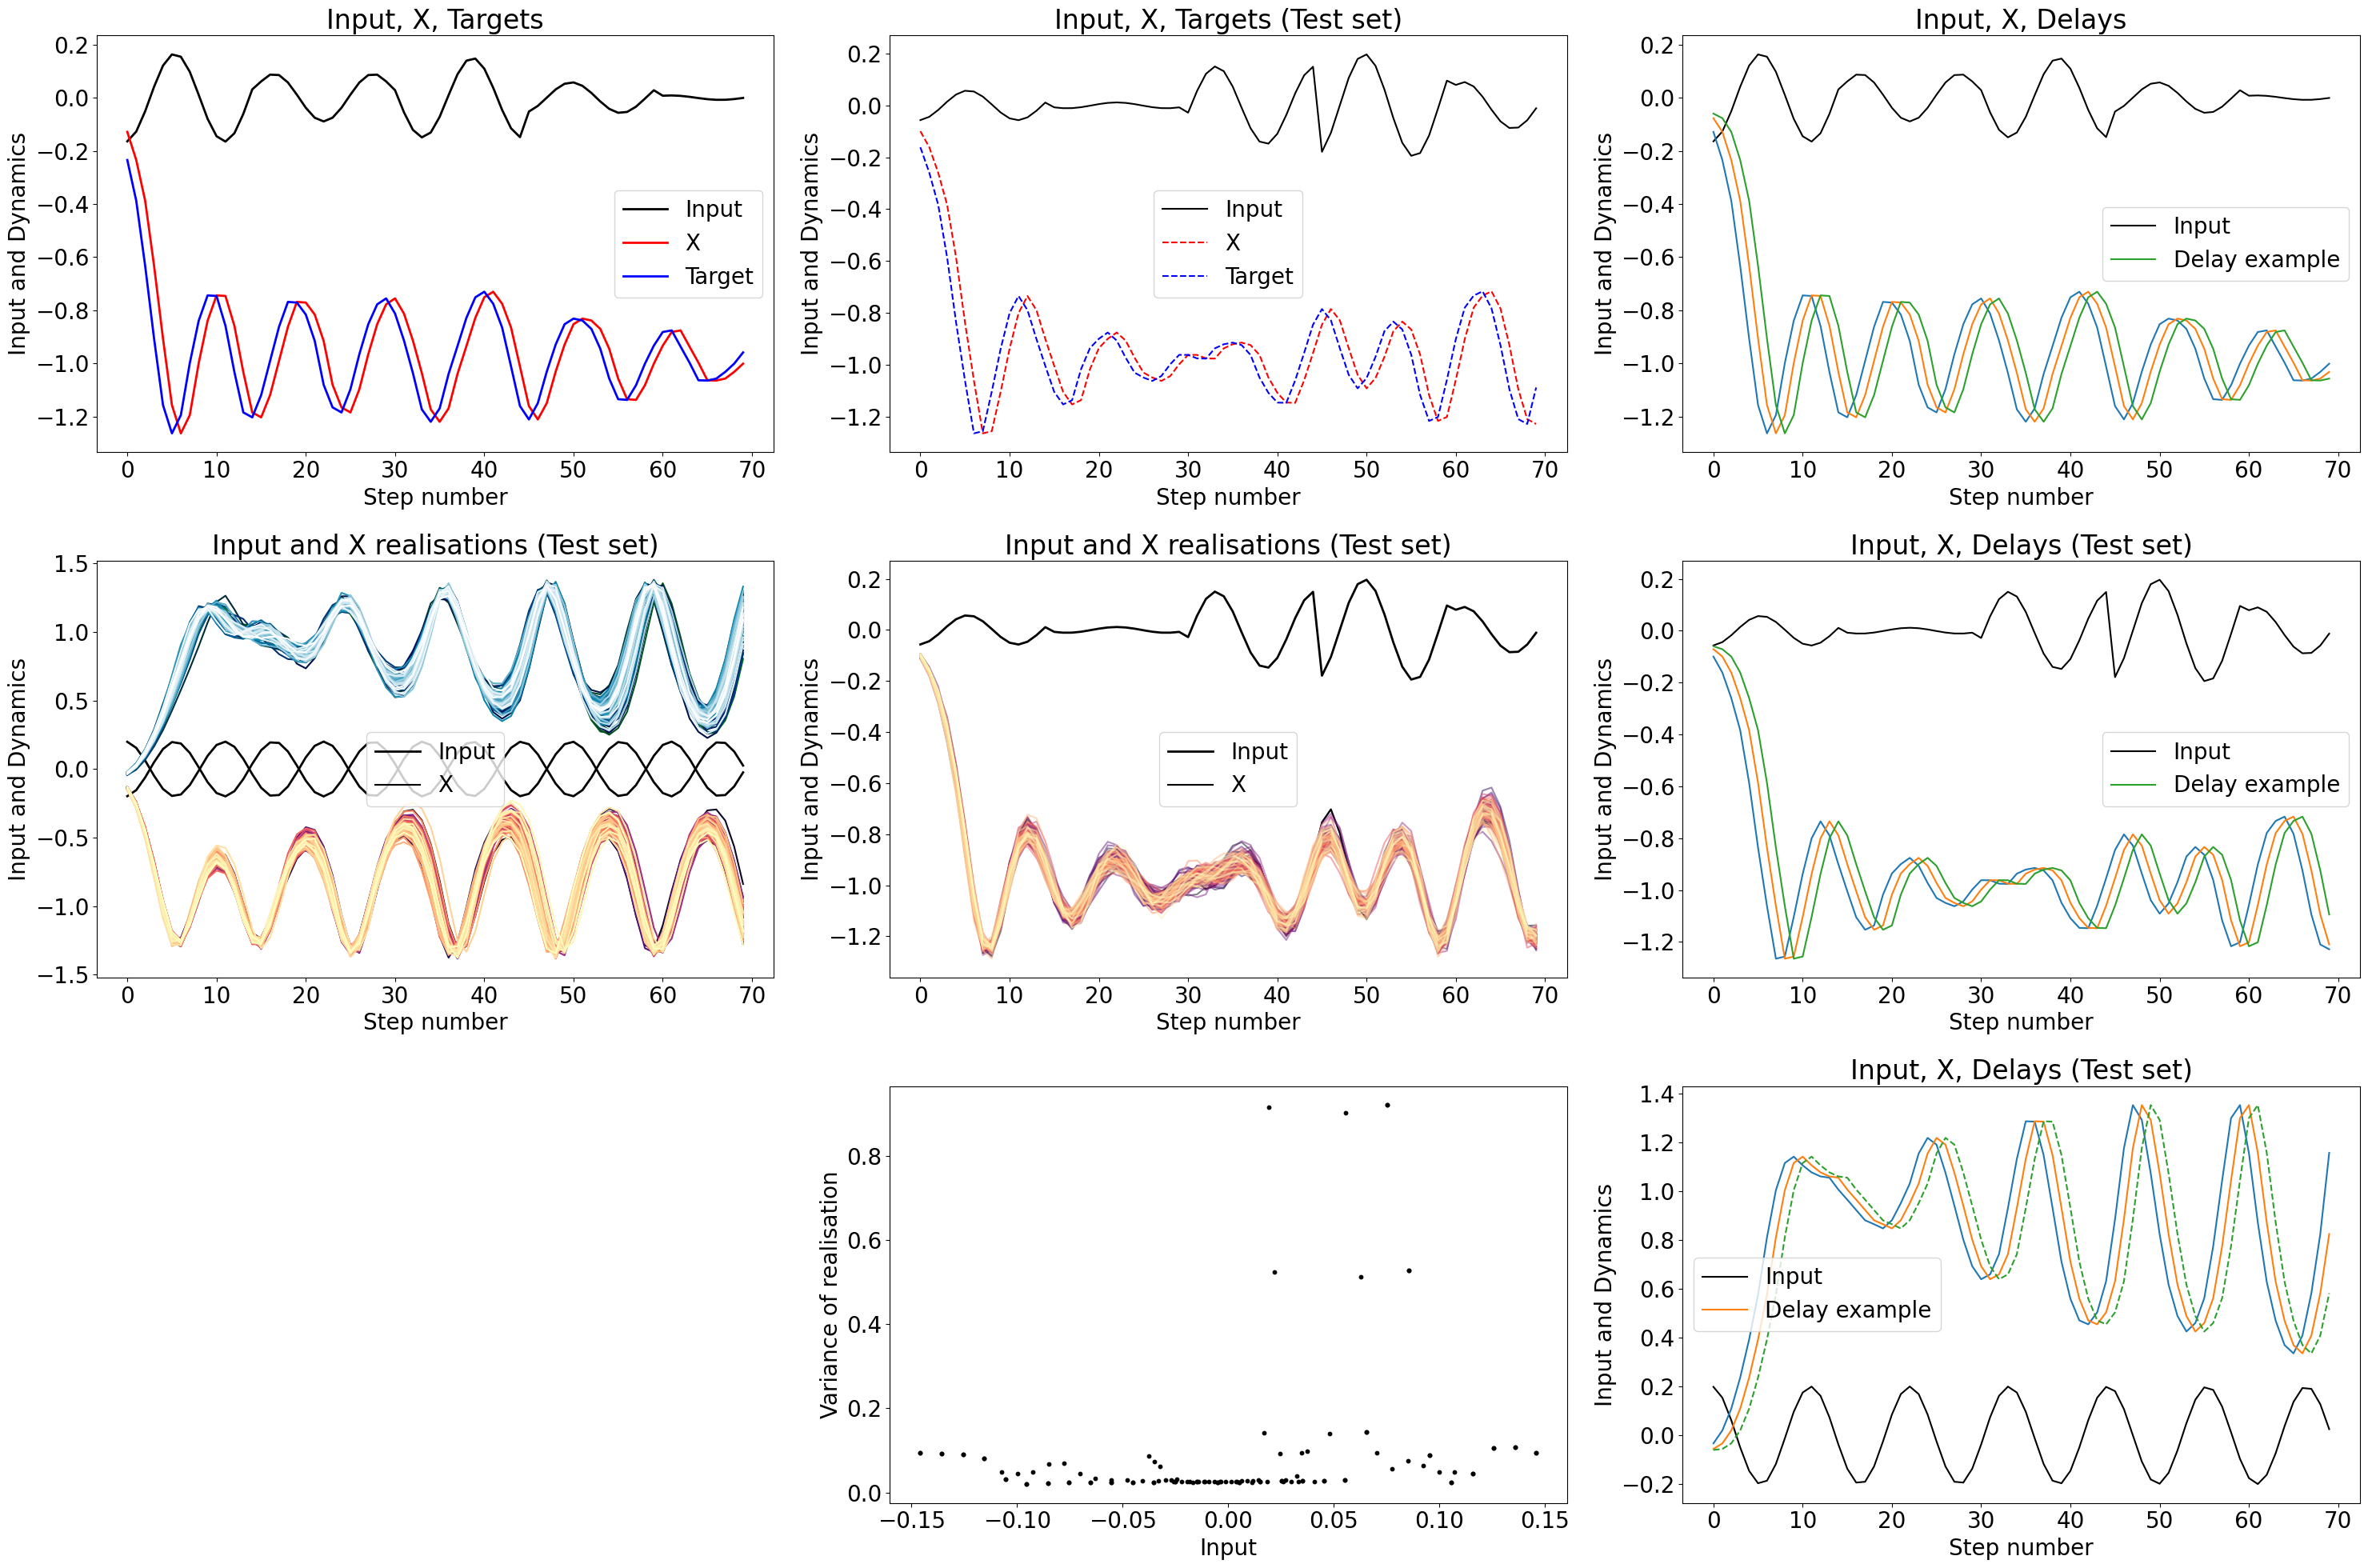

In [3]:
print(Dynamical_System)
if Dynamical_System=='LI':
    
    from LI_Definition import *
    
    ## The following parameters define the shape of the square waves-like input to the dynamical system.
    ## This defined the number of input changes per trajectory. T_steps[0] implies a generation of N trajectories 
    ## where the input changes T_steps[0] times
    T_steps=[50,5] 
    
    ## The number of steps over which an input value is repeated.
    Repeat=[5,50]

        
if Dynamical_System=='DO':
    
    from DO_Definition import *
    
    ## Similar to the above
    T_steps=[20,6]
    Repeat=[15,50]


if Dynamical_System=='LI' or Dynamical_System=='DO':
    
    ## binary mask that defines where the noise, in the analytical system, is present
    sigmas=torch.ones([NX_dim+N_aux,N_noise],device=device)

    if N_aux>0:
        sigmas[0,:]=0

    
    ## Definition of the object to generate the data for the analytical models
    GD=Generate_Data(DO,Noise_SigXI,Preprocess_S,sigmas)
    
    ## Dataset construction
    S, Input, Target, S_te, Input_te, Target_te, S_val, Input_val, Target_val, S_te_ordered, Input_te_ordered,    Target_te_ordered=GD.Generate_DataSet(X0,Amplitude,T_steps,Repeat)
    
    
    ## length of the segments over which the system performs backpropagation
    T_horizon=10
    
    ## Auxiliary variables
    N_int_aux=10
    N_ext_aux=0
    N_aux_model=N_int_aux+N_ext_aux
    
    ## binary mask for the model
    N_noise=2
    sigmas_model=torch.zeros([N_aux_model+NX_dim*(N_delays+1),N_noise],device=device)
    
    ## Learning rates, batch size, magnitude of the penalty term for gradient clipping
    etas=[0.0001,0.00005,0.0005]
    batch_size=100
    lamda=10

    t0=torch.tensor(0.)

    F_Ns=torch.tensor([Target.size()[1]+1,200,Target.size()[1]])

    G_out=sigmas_model.size()[0]
    G_Ns=torch.tensor([Target.size()[1]+1,500,500,G_out*N_noise])
        
    D_Ns=torch.tensor([T_horizon*NX_dim+T_horizon*N_S,500,500,1])
    
    N_datasets=1
    
    
    ## We embed the data into lists because of the possibility of having multiple datasets, with different temporal lengths
    ## For instance, for the nanorings, we have two datasets.
    Input=[Input]
    Input_te=[Input_te]
    Input_val=[Input_val]
    Target=[Target]
    Target_te=[Target_te]
    Target_val=[Target_val]
    
    Train_F2=False ## The deterministic component is only trained in the first phase
    
    
if Dynamical_System=='Rings':
    
    ## In this case, we load the experimental data
    cwd = os.getcwd()
    path = cwd+'/Data_Rings/'
    
    ## Dataset 1
    Input, Input_val, Input_te = torch.split(torch.from_numpy(np.load(path+'S_sinx_sin2x.npy')).to('cuda').float(), [18000, 1000, 1000])
    Target, Target_val, Target_te = torch.split(torch.from_numpy(np.load(path+'X_sinx_sin2x.npy')).to('cuda').float(), [18000, 1000, 1000])

    Input1, Input_val1, Input_te1 = torch.split(torch.from_numpy(np.load(path+'S_noise_data2x.npy')).to('cuda').float(), [800, 100, 100])
    Target1, Target_val1, Target_te1 = torch.split(torch.from_numpy(np.load(path+'X_noise_data2x.npy')).to('cuda').float(), [800, 100, 100])
    
    ## Dataset 2
    Input_new=torch.reshape(Input1, [-1, Input1.size()[2], Input1.size()[3]])
    Target_new=torch.reshape(Target1, [-1, Target1.size()[2], Target1.size()[3]])


    Input=[Input,Input_new]
    Target=[Target,Target_new]

    Input_val=[Input_val.unsqueeze(1),Input_val1]
    Target_val=[Target_val.unsqueeze(1), Target_val1]

    Input_te=[Input_te.unsqueeze(1),Input_te1]
    Target_te=[Target_te.unsqueeze(1), Target_te1]

    N_datasets=2

    T_horizon=50

    N_int_aux=10
    N_ext_aux=0
    N_aux_model=N_int_aux+N_ext_aux


    sigmas_model=torch.zeros([N_aux_model+NX_dim*(N_delays+1),2],device=device)
    N_noise=sigmas_model.size()[1]

    etas=[0.001,0.000005,0.000005]
    batch_size=50
    lamda=10

    t0=torch.tensor(0.)
    data_type=0
    X0=torch.clone(Input[data_type][0:batch_size,N_S:,0])

    F_Ns=torch.tensor([Input[0].size()[1],300,250,200,5])

    G_out=sigmas_model.size()[0]
    G_Ns=torch.tensor([Input[0].size()[1],300,250,200,G_out*N_noise])
        
    D_Ns=torch.tensor([T_horizon*NX_dim+T_horizon*N_S,300,250,200,1])
        
    Train_F2=True ## The deterministic comonent is adapted also in the second phase

if Dynamical_System=='ASVI':
    
    ## In this case, we load the experimental data
    cwd = os.getcwd()
    path = cwd+'/Data_ASVI/'
    
    ## Dataset 1
    Input, Input_val, Input_te = torch.split(torch.from_numpy(np.load(path+'Inputs_NODE_Shifted_thinbar_crop2.npy')).to('cuda').float().permute(0, 2, 1), [25298, 1000, 1000])
    Target, Target_val, Target_te = torch.split(torch.from_numpy(np.load(path+'Targets_NODE_Shifted_thinbar_crop2.npy')).to('cuda').float().permute(0, 2, 1), [25298, 1000, 1000])

    Input1 = torch.from_numpy(np.load(path+'Inputs_Noise_ASVI.npy')).to('cuda').float().unsqueeze(0).permute(0, 1, 3, 2)
    Input_val1 = torch.clone(Input1)
    Input_te1 = torch.clone(Input1)
    Target1 = torch.from_numpy(np.load(path+'Targets_Noise_ASVI.npy')).to('cuda').float().unsqueeze(0).permute(0, 1, 3, 2)
    Target_val1 = torch.clone(Target1)
    Target_te1 = torch.clone(Target1)
    ## Dataset 2
    Input_new=torch.reshape(Input1, [-1, Input1.size()[2], Input1.size()[3]])
    Target_new=torch.reshape(Target1, [-1, Target1.size()[2], Target1.size()[3]])


    Input=[Input,Input_new]
    Target=[Target,Target_new]

    Input_val=[Input_val.unsqueeze(1),Input_val1]
    Target_val=[Target_val.unsqueeze(1), Target_val1]

    Input_te=[Input_te.unsqueeze(1),Input_te1]
    Target_te=[Target_te.unsqueeze(1), Target_te1]

    N_datasets=2

    T_horizon=18

    N_int_aux=10
    N_ext_aux=0
    N_aux_model=N_int_aux+N_ext_aux


    sigmas_model=torch.zeros([N_aux_model+NX_dim*(N_delays+1),2],device=device)
    N_noise=sigmas_model.size()[1]

    etas=[0.001,0.000005,0.000005]
    batch_size=50
    lamda=10

    t0=torch.tensor(0.)
    data_type=0
    X0=torch.clone(Input[data_type][0:batch_size,N_S:,0])

    F_Ns=torch.tensor([Input[0].size()[1],300,250,200,60])

    G_out=sigmas_model.size()[0]
    G_Ns=torch.tensor([Input[0].size()[1],300,250,200,G_out*N_noise])
        
    D_Ns=torch.tensor([T_horizon*NX_dim+T_horizon*N_S,300,250,200,1])
        
    Train_F2=False ## The deterministic comonent is adapted also in the second phase

    
Train_Type=[0,1,1]





In [5]:
## INITIALISATION OF THE NEURAL SDE/ODE

Manual_load_of_weights=False ## This can be used to load manually weights for the determinstic component (if one has 
## a previous neural ODE model). You will need a model to set it to True...

if Manual_load_of_weights:

    N_SDE=torch.load("Parameters_SDE_2_Rings_NDelaysCopy_4T_horizon_50.pt")

    load_weightsF=[[N_SDE.F.F[0].weight.T,N_SDE.F.F[2].weight.T,N_SDE.F.F[4].weight.T,N_SDE.F.F[6].weight.T],\
                [N_SDE.F.F[0].bias,N_SDE.F.F[2].bias,N_SDE.F.F[4].bias,N_SDE.F.F[6].bias]]


    load_weightsD=[[N_SDE.D.D[0].weight.T,N_SDE.D.D[2].weight.T,N_SDE.D.out.weight.T],\
                [N_SDE.D.D[0].bias,N_SDE.D.D[2].bias,N_SDE.D.out.bias]]

else:

    load_weightsF=[]

    load_weightsD=[]


    
#F_Ns = torch.tensor([61, 300, 200, 100, 60])
N_SDE=NeuralSDE_BPTT(F_Ns,G_Ns,D_Ns,N_int_aux,N_ext_aux,sigmas_model)

N_SDE.Initialise_Hyperparameters(dt,etas,lamda,sigmas_model,Train_Type)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
device = device

### Training phases

The following cells correspond to the two training phases of the algorithm.
First, the deterministic component F is optimised. Then, the G and the G2F parameters.

During the first phase, the error on the means given by the Autocov function on the validation trajectories is used as stopping criterion for the algorithm. In the second phase, the errors on the statistics, including errors on the estimation of the variance and autocovariance structure, are adopted as stopping criterion.

We notice how the Autocov function takes as input 4-d data structures. In particular, it needs two arguments, one corresponding to the generated trajectories and the other to the real ones. The 4-d structure is organised as $[N_{traj}, N_{realizations},N_X,T]$, where $N_{traj}$ stands for different inputs trajectories, $N_{realizations}$
corresponds to different realizations of the system dynamics, $N_X$ the dimensionality of the considered trajectories, and T time. For instance, a set $[0,:,:,:]$ corresponds to different realisations of the system for input number 0. In our cases, we gathered (or generated) the data to have different responses of exactly the same inputs, in order to consrtuct the dataset with these 4-d data structures. However, this is not possible in general. In such cases, one should decide what can be clustered together and trated as similar inputs/conditions.
We notice how the utilization of the Autocov function is not fundamental for the training of the algorithm, but only as a useful stopping criterion that can help against the learning instabilities of GANs. 

For the second phase optimisation, the variable Train_Type specifies the way of training the GAN. Option $[1,0,0]$ is the standard Wesserstein loss with gradient penalty, Options $[0,1,0]$ and $[0,0,1]$ change the cost function for the generator to the minimisation of the mean-squared error computer over statistical properties between discriminator's features computed from real and fake (generated) data. In particular, denoting the activities of a layer of the discriminator as $\mathbf{z}^{d}(real)$ and $\mathbf{z}^{d}(fake)$, Option $[0,1,0]$ minimizes $\rm{MSE}\Big(<\mathbf{z}^{d}(real)>,<\mathbf{z}^{d}(fake)>\Big)$, while option $[0,0,1]$ minimizes $\rm{MSE}\Big(\sigma(\mathbf{z}^{d}(real)),\sigma(\mathbf{z}^{d}(fake)\Big)$, where $\sigma$ is the standard deviation.      
We suggest using either Train_Trype=$[1,0,0]$, or Train_Trype=$[0,1,1]$, which combines the two error functions above. The latter is usually slower (also because there is a decrease of the effective learning rate with this error function), but also more stable.

NOTE: The printed errors (give by the Autocov function), in order, are: the error on the mean of the distributions (in absolute value, not squared), variance, and autocovariance.


In [6]:
## Training iterations

N_ST1=40000 ## NUMBER OF ITERATIONS IN THE FIRST PHASE, TRANING THE DETERMINSITIC COMPONENT
N_ST=30000  ## NUMBER OF ITERATIONS STOCHASTIC TRAINING
D_step=5

First Phase of Training
0
New Plot, Old error:  tensor(1) New Error:  tensor(0.1597)


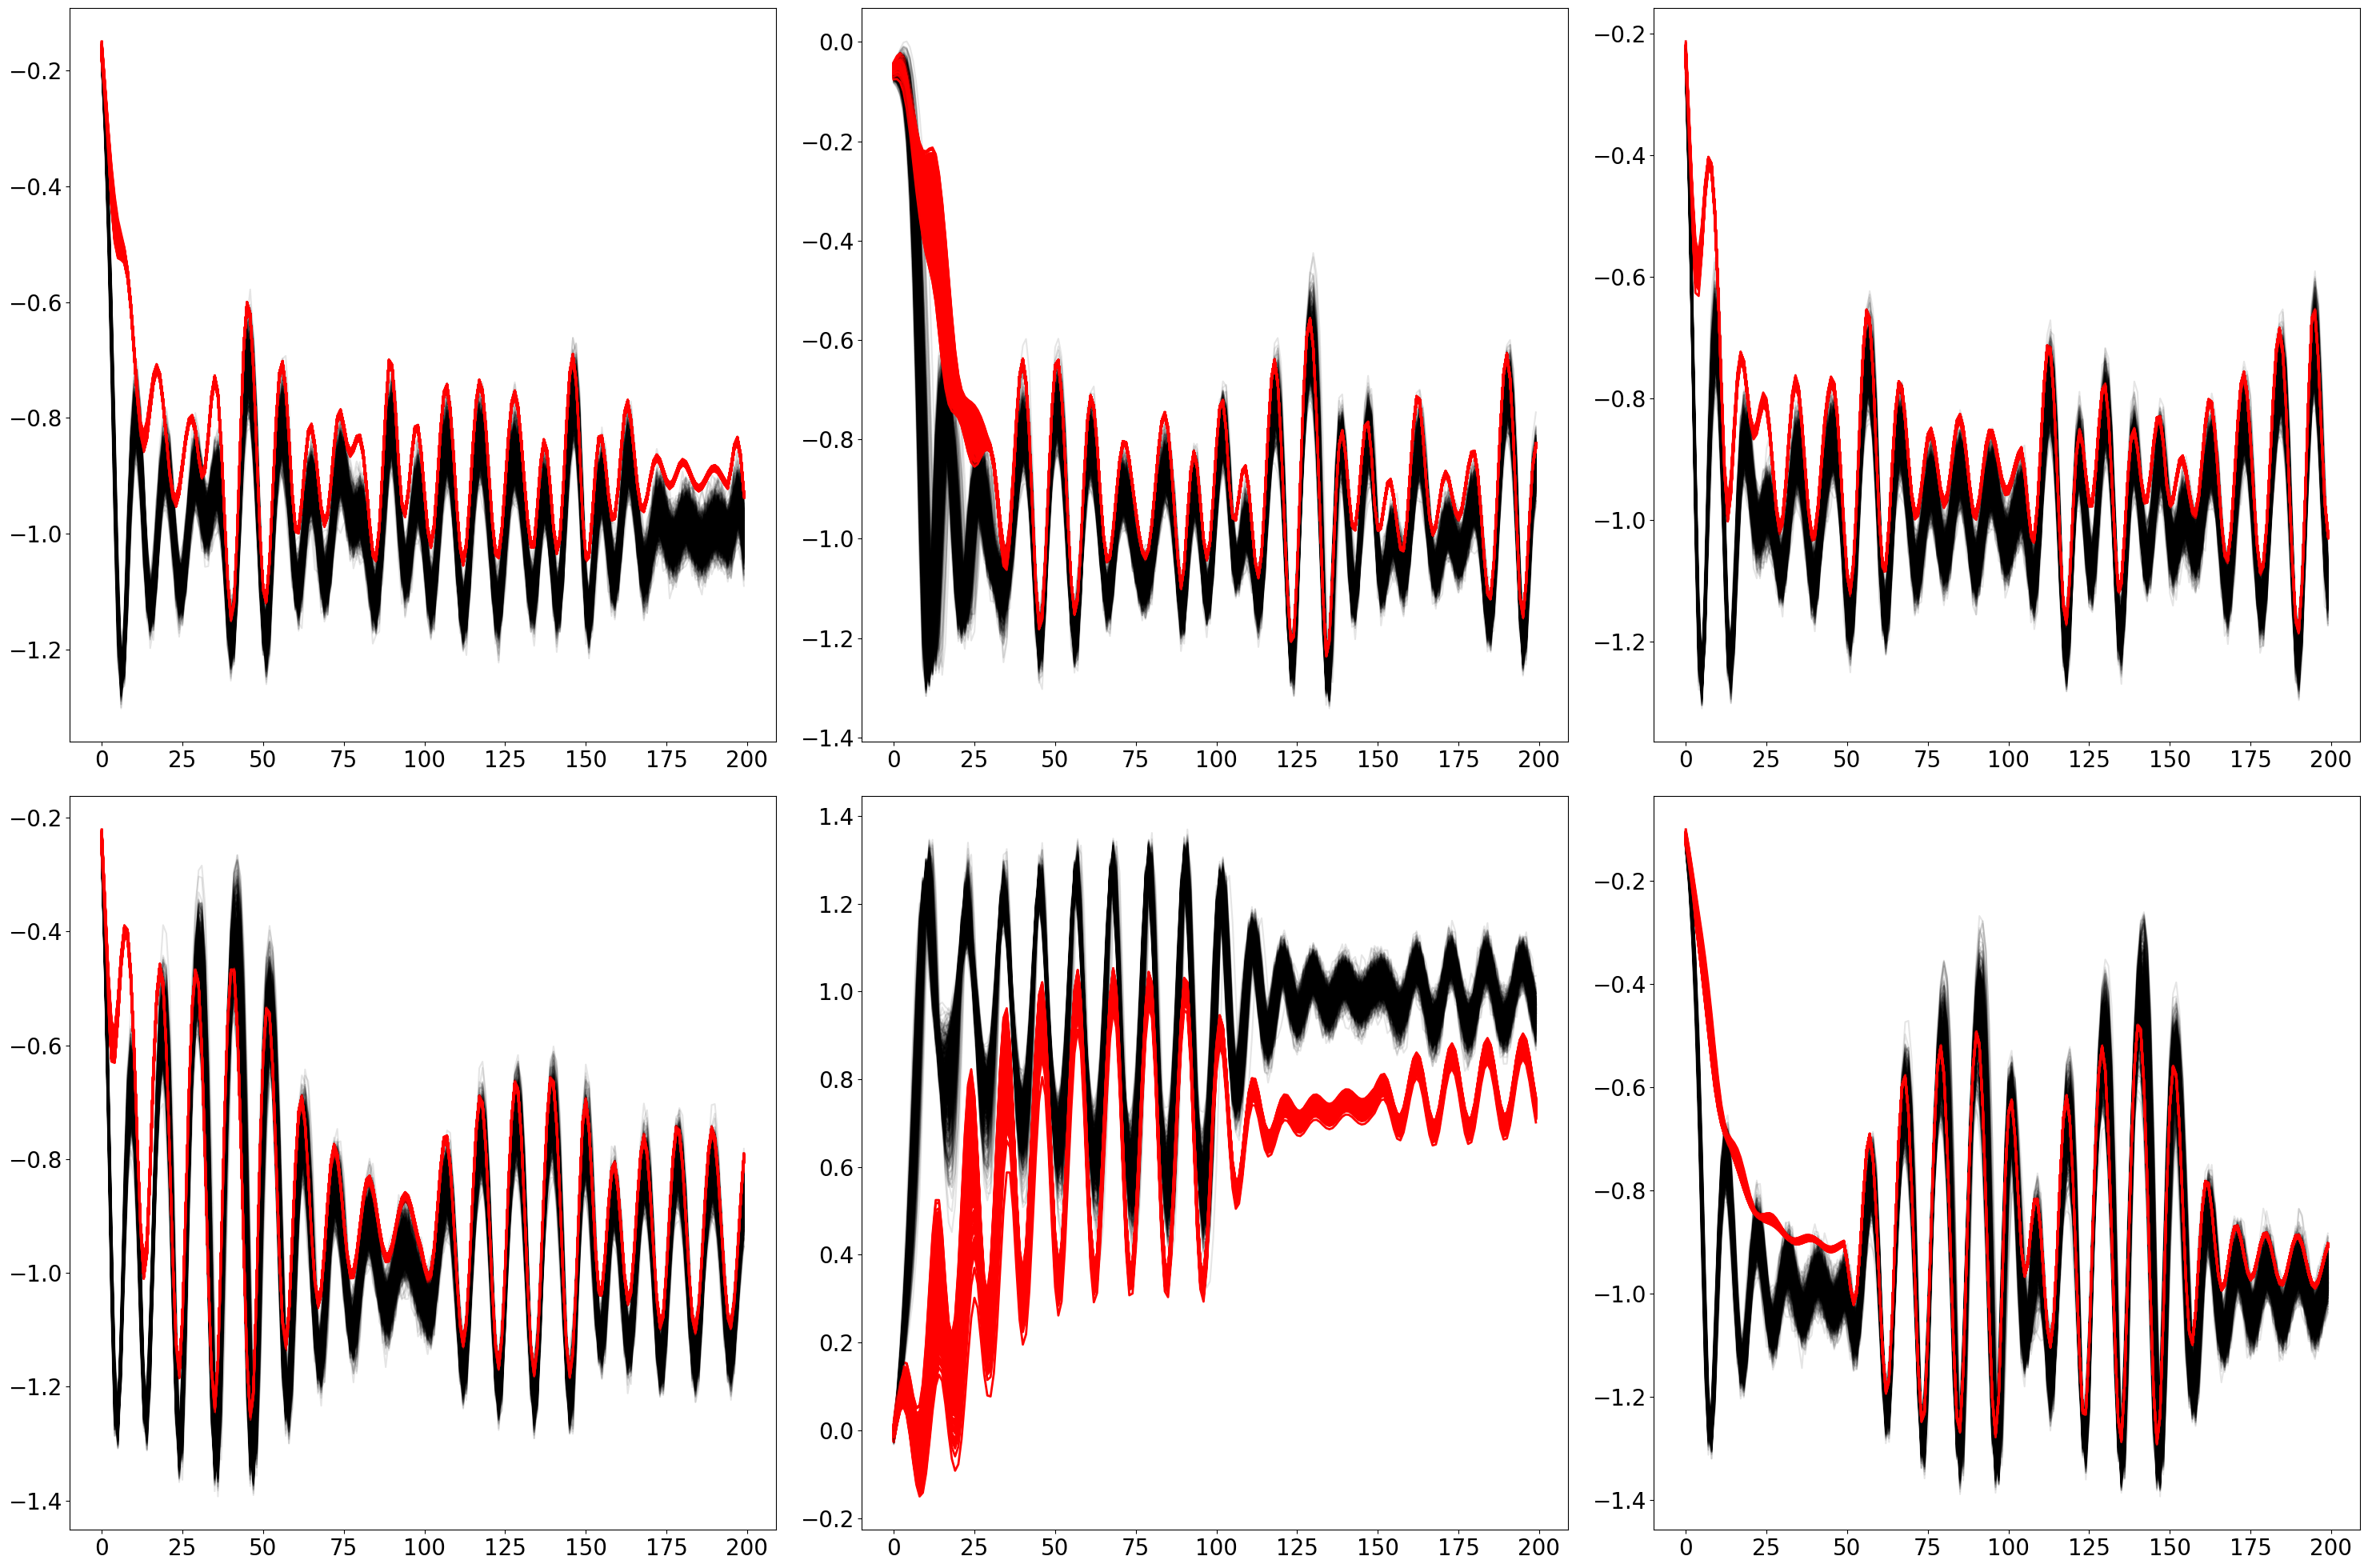

0  Errors on distributions Data: tensor([0.1597, 0.2464, 0.1618]) tensor([0.0918, 0.1049, 0.1191])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
2

KeyboardInterrupt: 

In [8]:

N_SDE.SDE=False ## Setting it to False means that we will use a deterministic numerical method for convenience of
N_SDE.integrate=N_SDE.Int_Ode.RK2  ## computation. In this phase, only the deterministic part is trained.    

Err=torch.zeros([N_ST1])

print('First Phase of Training')
Best_Error=torch.tensor(1)

Saving=False
Plot_Res=True

ERR1_val=torch.zeros([N_ST1,1,3])
ERR1_te=torch.zeros([N_ST1,1,3])


for n in range(N_ST1):
    print(n)
    if n>0:

        data_type=np.random.randint(0,N_datasets)

        rand_ind=np.random.randint(0,Input[data_type].size()[0],(batch_size,))
        rand_t=np.random.randint(0,Input[data_type].size()[2]-T_horizon,(batch_size,))

        S=torch.zeros([batch_size,Input[data_type].size()[1],T_horizon]).to(device)
        Tg=torch.zeros([batch_size,Target[data_type].size()[1],T_horizon]).to(device)

        for k in range(batch_size):

            S[k,:,:]=torch.clone(Input[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])
            Tg[k,:,:]=torch.clone(Target[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])

        mse=N_SDE.Train_F(S,Tg,torch.tensor(rand_t*dt,device=device))
        D_cost, D_W, fake_data=N_SDE.Train_D(S, Tg, torch.tensor(rand_t*dt,device=device))

        Err[n]=mse.detach()

    
    if n%1000==0:
        
        ## Test Sets
        
        ind_data=0
        if Dynamical_System=='Rings' or Dynamical_System=='ASVI':
            
            ind_data=1
        
        Generated_te=torch.zeros_like(Target_te[ind_data],device=device)
        
        for m in range(Input_te[ind_data].size()[0]):
            
            X_generated=N_SDE.SDE_Seqforward(Input_te[ind_data][m,:,:,:],t0)
            
            Generated_te[m,:,:,:]=X_generated
            
        _,_,_,_,_,_, Errors_te=AutoCov(Generated_te.to('cpu'),Target_te[ind_data].to('cpu'))
        
        ## Validation Sets
        
        Generated_val=torch.zeros_like(Target_val[ind_data],device=device)
        
        for m in range(Input_val[ind_data].size()[0]):

            X_generated=N_SDE.SDE_Seqforward(Input_val[ind_data][m,:,:,:],t0)
                
            Generated_val[m,:,:,:]=X_generated
    
        _,_,_,_,_,_, Errors_val=AutoCov(Generated_val,Target_val[ind_data])
        
        Errors_=Errors_val[0].detach().to('cpu').unsqueeze(0)
        
        Best_Error_new=torch.min(torch.concat([Best_Error.unsqueeze(0),Errors_],0))
        
        ## Saving errors
        
        ERR1_val[n,0,:]=Errors_val.detach().to('cpu')
        ERR1_te[n,0,:]=Errors_te.detach().to('cpu')
        
        if Best_Error_new<Best_Error and Plot_Res==True:
            
            print('New Plot, Old error: ', Best_Error, 'New Error: ', Best_Error_new)
                        
            Nplots_x=3
            Nplots_y=2
            T_plots=200
            choice=np.int32(np.linspace(0,Target_val[ind_data].size()[0]-1,Nplots_x*Nplots_y))
            
            fig, axs = plt.subplots(Nplots_y, Nplots_x, figsize=(30,20))
            
            for i in range(Nplots_y):
                for j in range(Nplots_x):
                    
                    for k in range(Target_val[ind_data].size()[1]):

                    
                        if Dynamical_System=='ASVI':
                        
                            axs[i,j].plot(Target_val[ind_data][choice[i*Nplots_x],k,j*5+i*15,0:T_plots].to('cpu'),'black', alpha=0.05)
                            axs[i,j].plot(Generated_val[choice[i*Nplots_x],k,j*5+i*15,0:T_plots].to('cpu'),'red', alpha=0.05)
                    
                        else:
                            
                            axs[i,j].plot(Target_val[ind_data][choice[i*Nplots_x+j],k,0,0:T_plots].to('cpu'),'black',alpha=0.1)
                            axs[i,j].plot(Generated_val[choice[i*Nplots_x+j],k,0,0:T_plots].to('cpu'),'red',linewidth=2)
                        
                        
                        
            plt.show()
            
        if Best_Error_new<Best_Error and Saving==True:
            
            print('Saving... New Error: ', Best_Error_new )
            path=""
            title_start="Parameters_SDE_"+str(RK)+"_Rings_NDelaysCopy_"+str(N_delays)+'T_horizon_'+str(T_horizon)+'_1fInput'

            torch.save(N_SDE,title_start+'.pt')
        
        Best_Error=torch.clone(Best_Error_new)
        
        print(n,' Errors on distributions', 'Data:', Errors_val, Errors_te)
        
        

Generated_val_before=torch.clone(Generated_val)
Generated_te_before=torch.clone(Generated_te)


In [ ]:

Saving=False
Loading=False

ERR2_val=torch.zeros([N_ST,1,3])
ERR2_te=torch.zeros([N_ST,1,3])

if Loading:
    
    ## Here one can load a pytorch model
    N_SDE=torch.load("Parameters_SDE_2_Rings_NDelaysCopy_4T_horizon_50_1fInput.pt")

print('Second Phase of Training')

N_SDE.opt_F.param_groups[0]['lr']=etas[1]

N_SDE.SDE=True




Train_Type=[0,1,1]
N_SDE.Train_Type=Train_Type


N_aux_model=N_aux_model ## Possible to change the number of auxiliary variables

sigmas_model=torch.zeros([N_aux_model+NX_dim*(N_delays+1),2],device=device)

if N_aux_model>0:
    
    sigmas_model[-N_aux_model:,:]=1
    
if N_aux_model==0:
    
    sigmas_model[-NX_dim:,:]=1
    
print('Noise Variance Binary Mask:', sigmas_model)

N_SDE.Int_Sde.sigmas=sigmas_model

####This is to override the previous definition of G if you want to change the the number of auxiliary variables

G_out=sigmas_model.size()[0]
G_Ns=torch.tensor([Input[0].size()[1],300,250,200,G_out*N_noise])
N_SDE.Override_G(G_Ns,N_aux_model,N_ext_aux,sigmas_model)
N_SDE.F.N_aux=N_aux_model
N_SDE.F.N_ext_aux=N_ext_aux

################



Best_Error=torch.tensor(1.) ## Value to surpass

for n in range(N_ST):
    
    for m in range(D_step):
        
        data_type=np.random.randint(0,N_datasets)
    
        rand_ind=np.random.randint(0,Input[data_type].size()[0],(batch_size,))
        rand_t=np.random.randint(0,Input[data_type].size()[2]-T_horizon,(batch_size,))

        S=torch.zeros([batch_size,Input[data_type].size()[1],T_horizon]).to(device)
        Tg=torch.zeros([batch_size,Target[data_type].size()[1],T_horizon]).to(device)

        for k in range(batch_size):

            S[k,:,:]=torch.clone(Input[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])
            Tg[k,:,:]=torch.clone(Target[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])

        
        D_cost, D_W, fake_data=N_SDE.Train_D(S, Tg, torch.tensor(rand_t*dt,device=device))
        
    data_type=np.random.randint(0,N_datasets)
    
    rand_ind=np.random.randint(0,Input[data_type].size()[0],(batch_size,))
    rand_t=np.random.randint(0,Input[data_type].size()[2]-T_horizon,(batch_size,))

    S=torch.zeros([batch_size,Input[data_type].size()[1],T_horizon]).to(device)
    Tg=torch.zeros([batch_size,Target[data_type].size()[1],T_horizon]).to(device)

    for k in range(batch_size):

        S[k,:,:]=torch.clone(Input[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])
        Tg[k,:,:]=torch.clone(Target[data_type][rand_ind[k],:,rand_t[k]+np.arange(0,T_horizon)])
    
    G_cost, fake_data=N_SDE.Train_G(S,Tg,torch.tensor(rand_t*dt,device=device))
    
    if Train_F2:
        
        mse=N_SDE.Train_F(S,Tg,torch.tensor(rand_t*dt,device=device))
    
    
    if n%200==0:
        
        ## Test Sets
        
        ind_data=0
        if Dynamical_System=='Rings' or Dynamical_System=='ASVI':
            
            ind_data=1
        
        Generated_te=torch.zeros_like(Target_te[ind_data],device=device)
        
        for m in range(Input_te[ind_data].size()[0]):
            
            X_generated=N_SDE.SDE_Seqforward(Input_te[ind_data][m,:,:,:],t0)
            
            Generated_te[m,:,:,:]=X_generated
            
        _,_,_,_,_,_, Errors_te=AutoCov(Generated_te.to('cpu'),Target_te[ind_data].to('cpu'))
        
        ## Validation Sets
        
        Generated_val=torch.zeros_like(Target_val[ind_data],device=device)
        
        for m in range(Input_val[ind_data].size()[0]):

            X_generated=N_SDE.SDE_Seqforward(Input_val[ind_data][m,:,:,:],t0)
                
            Generated_val[m,:,:,:]=X_generated
    
        _,_,_,_,_,_, Errors_val=AutoCov(Generated_val,Target_val[ind_data])
        
        Errors_=Errors_val[0].detach().to('cpu').unsqueeze(0)
        
        Best_Error_new=torch.min(torch.concat([Best_Error.unsqueeze(0),Errors_],0))
        
        ## Saving errors
        
        ERR2_val[n,0,:]=Errors_val.detach().to('cpu')
        ERR2_te[n,0,:]=Errors_te.detach().to('cpu')
                
        Errors_= torch.sum(Errors_val).detach().to('cpu').unsqueeze(0)
        
        Best_Error_new=torch.min(torch.concat([Best_Error.unsqueeze(0),Errors_],0))
        
        
        if Best_Error_new<Best_Error and Plot_Res==True:
            
            print('New Plot, Old error: ', Best_Error, 'New Error: ', Best_Error_new)
            
            choice=np.int32(np.linspace(0,Target_val[ind_data].size()[0]-1,6))
            
            Nplots_x=3
            Nplots_y=2
            T_plots=200
            fig, axs = plt.subplots(Nplots_y, Nplots_x, figsize=(30,20))
            
            for i in range(Nplots_y):
                for j in range(Nplots_x):
                    
                    for k in range(Target_val[ind_data].size()[1]):

                        if Dynamical_System=='ASVI':
                        
                            axs[i,j].plot(Target_val[ind_data][choice[i*Nplots_x],k,j*5+i*15,0:T_plots].to('cpu'),'black', alpha=0.05)
                            axs[i,j].plot(Generated_val[choice[i*Nplots_x],k,j*5+i*15,0:T_plots].to('cpu'),'red', alpha=0.05)
                    
                        else:
                            
                            axs[i,j].plot(Target_val[ind_data][choice[i*Nplots_x+j],k,0,0:T_plots].to('cpu'),'black',alpha=0.1)
                            axs[i,j].plot(Generated_val[choice[i*Nplots_x+j],k,0,0:T_plots].to('cpu'),'red',linewidth=2)
                        
            plt.show()
        
                              
        if Best_Error_new<Best_Error and Saving==True and Errors_val1[0]<Best_err_av+0.05*Best_err_av:
            
            print('Saving... New Error: ', Best_Error_new )
            path=""
            title_start="Parameters_SDE_"+str(RK)+"_Rings_NDelaysCopy_"+str(N_delays)+'T_horizon_'+str(T_horizon)+'_'+str(Train_Type)+'_V2_1f'

            torch.save(N_SDE,title_start+'.pt')
        
        Best_Error=torch.clone(Best_Error_new)
        
        
        print(n,' Errors on distributions', 'Data:', Errors_val, Errors_te)
        